# Check lib versions

In [1]:
%%bash
# Check nvcc version
nvcc -V
echo
# Check GCC version
gcc --version
echo
# Check the version of torch and cuda packages
pip list | grep "torch\|cuda"

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Tue_May__3_18:49:52_PDT_2022
Cuda compilation tools, release 11.7, V11.7.64
Build cuda_11.7.r11.7/compiler.31294372_0

gcc (Ubuntu 9.4.0-1ubuntu1~20.04.1) 9.4.0
Copyright (C) 2019 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.


cuda-python                   11.6.1
cupy-cuda115                  9.6.0
dask-cuda                     22.4.0
nvidia-dali-cuda110           1.13.0
pytorch-quantization          2.1.2
torch                         1.12.0a0+8a1a93a
torch-tensorrt                1.1.0a0
torchtext                     0.13.0a0
torchvision                   0.13.0a0


# Setup Weights & Biases

In [2]:
import wandb
import os

os.environ["WANDB_NOTEBOOK_NAME"] = "mmdetecttion_custom_dataset"

wandb.init(project="anastomoticpatchdetection", entity="mjirik")

wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find mmdetecttion_custom_dataset.
wandb: Currently logged in as: mjirik. Use `wandb login --relogin` to force relogin


In [3]:
# Some basic setup

# import some common libraries
import logging
import mmcv.utils

logger = mmcv.utils.get_logger(name="general_logger", log_level=logging.DEBUG)

import matplotlib.pyplot as plt
import numpy as np

# Check Pytorch installation
import torch, torchvision

print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation
import mmdet

logger.debug(f"mmdet.version={mmdet.__version__}")

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version

logger.debug(get_compiling_cuda_version())
logger.debug(get_compiler_version())
from pprint import pprint, pformat
from mmdet.datasets import build_dataset
from mmdet.apis import train_detector
from mmcv import Config
from mmdet.apis import set_random_seed
from pathlib import Path
import os.path as osp
import os
import mmcv
from mmcv.runner import load_checkpoint

from mmdet.apis import inference_detector, show_result_pyplot
from mmdet.models import build_detector

import skimage
import random


2022-09-01 20:32:04,709 - general_logger - DEBUG - mmdet.version=2.25.0


1.12.0a0+8a1a93a True


2022-09-01 20:32:05,060 - general_logger - DEBUG - 11.7
2022-09-01 20:32:05,061 - general_logger - DEBUG - GCC 9.4


NOTE! Installing ujson may make loading annotations faster.


In [4]:
mmdet.__version__

'2.25.0'

# Prepare data

Download and copy dataset to scratch dir.

In [5]:
scratchdir = Path(os.getenv("SCRATCHDIR", "."))

In [6]:
# !mkdir -p ~/data/orig/cocos2d
# # !cd ~/data/orig/cocos2d
# !wget https://github.com/Tony607/detectron2_instance_segmentation_demo/releases/download/V0.1/data.zip -O data.zip
# !unzip -o data.zip -d ~/data/orig/cocos2d > /dev/null
# !pwd

In [7]:
# !ls ~/data/orig/cocos2d

In [8]:
!echo "$SCRATCHDIR"

/scratch/mjirik/job_12614076.meta-pbs.metacentrum.cz


In [21]:
!mkdir -p "$SCRATCHDIR"/data/orig
!cp -r /storage/plzen4-ntis/projects/korpusy_cv/pilsen_pigs_patches/* "$SCRATCHDIR"/data/orig
!ls "$SCRATCHDIR"/data/orig

coco_test.json	coco_train.json  images_test  images_train


# Prepare checkpoint

In [10]:
import requests
import tqdm

def mywget(url, fname):
    fname = Path(fname)
    fname.parent.mkdir(parents=True, exist_ok=True)
    
    response = requests.get(url, stream=True)
    total_size_in_bytes= int(response.headers.get('content-length', 0))
    block_size = 1024 #1 Kibibyte
    progress_bar = tqdm.tqdm(total=total_size_in_bytes, unit='iB', unit_scale=True)
    with open(fname, 'wb') as file:
        for data in response.iter_content(block_size):
            progress_bar.update(len(data))
            file.write(data)
    progress_bar.close()
    if total_size_in_bytes != 0 and progress_bar.n != total_size_in_bytes:
        print("ERROR, something went wrong")

In [11]:
mywget(
    "https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco_20210526_095054-1f77628b.pth",
    scratchdir
    / "checkpoints/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco_20210526_095054-1f77628b.pth"
)

100%|██████████| 167M/167M [00:14<00:00, 11.3MiB/s] 


In [23]:


mmdetection_path = Path(mmdet.__file__).parent.parent

scratchdir = Path(os.getenv("SCRATCHDIR", "."))
logname = Path(os.getenv("LOGNAME", "."))
# from loguru import logger

local_input_data_dir = Path(scratchdir) / "data/orig/"
local_output_data_dir = Path(scratchdir) / "data/processed/"

logger.debug(f"outputdir={local_output_data_dir}")
logger.debug(f"input_data_dir={local_input_data_dir}")
logger.debug(f"input_data_dir exists={local_input_data_dir.exists()}")
logger.debug(f'input_data_dir glob={str(list(local_input_data_dir.glob("**/*")))}')

# Choose to use a config and initialize the detector
config = (
    mmdetection_path
    / "configs/faster_rcnn/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco.py"
)
logger.debug(f"config.exists={config.exists()}")
# Setup a checkpoint file to load
checkpoint_pth = (
    scratchdir
    / "checkpoints/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco_20210526_095054-1f77628b.pth"
)
logger.debug(f"checkpoint_pth.exists={checkpoint_pth.exists()}")

# Set the device to be used for evaluation
device = "cuda:0"

# Load the config
config = mmcv.Config.fromfile(config)
# Set pretrained to be None since we do not need pretrained model here
config.model.pretrained = None

# Initialize the detector
model = build_detector(config.model)

# Load checkpoint
checkpoint = load_checkpoint(model, str(checkpoint_pth), map_location=device)

# Set the classes of models for inference
model.CLASSES = checkpoint["meta"]["CLASSES"]

# We need to set the model's cfg for inference
model.cfg = config

# Convert the model to GPU
model.to(device)
# Convert the model into evaluation mode
model.eval()

# Use the detector to do inference
img = mmdetection_path / "demo/demo.jpg"
result = inference_detector(model, img)
model.show_result(
    img, result, out_file=local_output_data_dir / "demo_output.jpg"
)  # save image with result


# My dataset training
cfg = Config.fromfile(
    mmdetection_path
    / "configs/faster_rcnn/faster_rcnn_r50_caffe_fpn_mstrain_1x_coco.py"
)

# Modify dataset type and path
cfg.dataset_type = "CocoDataset"
cfg.data_root = str(local_input_data_dir)
# cfg.classes = (
#     "bobcat",
#     "opossum",
#     "empty",
#     "coyote",
#     "raccoon",
#     "bird",
#     "dog",
#     "cat",
#     "squirrel",
#     "rabbit",
#     "skunk",
#     "rodent",
#     "badger",
#     "deer",
#     "car",
#     "fox",
# )
# cfg.classes = ('date', 'fig', 'hazelnut',)
cfg.classes = ('patch_on',)

# cfg.data.test.type = "CocoDataset"
# cfg.data.test.data_root = str(local_input_data_dir)
# cfg.data.test.ann_file = "eccv_18_annotation_files_updated/trans_test_annotations.json"
# # cfg.data.test.ann_file = 'eccv_18_annotation_files/trans_test_annotations.json'
# cfg.data.test.img_prefix = "eccv_18_all_images_sm/"
# cfg.data.test.classes = cfg.classes

# cfg.data.train.type = "CocoDataset"
# cfg.data.train.data_root = str(local_input_data_dir)
# cfg.data.train.ann_file = "eccv_18_annotation_files_updated/train_annotations.json"
# # cfg.data.train.ann_file = 'eccv_18_annotation_files/train_annotations.json'
# cfg.data.train.img_prefix = "eccv_18_all_images_sm/"
# cfg.data.train.classes = cfg.classes

# cfg.data.val.type = "CocoDataset"
# cfg.data.val.data_root = str(local_input_data_dir)
# cfg.data.val.ann_file = "eccv_18_annotation_files_updated/trans_val_annotations.json"
# # cfg.data.val.ann_file = 'eccv_18_annotation_files/trans_val_annotations.json'
# cfg.data.val.img_prefix = "eccv_18_all_images_sm/"
# cfg.data.val.classes = cfg.classes


cfg.data.test.type = 'CocoDataset'
cfg.data.test.data_root = str(local_input_data_dir)
cfg.data.test.ann_file = 'coco_test.json'
cfg.data.test.img_prefix = './'
cfg.data.test.classes = cfg.classes

cfg.data.train.type = 'CocoDataset'
cfg.data.train.data_root = str(local_input_data_dir)
cfg.data.train.ann_file = 'coco_train.json'
cfg.data.train.img_prefix = './'
cfg.data.train.classes = cfg.classes

cfg.data.val.type = 'CocoDataset'
cfg.data.val.data_root = str(local_input_data_dir)
cfg.data.val.ann_file = 'coco_test.json'
cfg.data.val.img_prefix = './'
cfg.data.val.classes = cfg.classes


# modify num classes of the model in box head
cfg.model.roi_head.bbox_head.num_classes = 1



# If we need to finetune a model based on a pre-trained detector, we need to
# use load_from to set the path of checkpoints.
cfg.load_from = str(
    scratchdir
    / "checkpoints/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco_20210526_095054-1f77628b.pth"
)

# Set up working dir to save files and logs.
cfg.work_dir = str(local_output_data_dir / "tutorial_exps")

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
cfg.optimizer.lr = 0.02 / 8
cfg.lr_config.warmup = None
cfg.log_config.interval = 10

# Change the evaluation metric since we use customized dataset.
# cfg.evaluation.metric = 'mAP'
# We can set the evaluation interval to reduce the evaluation times
cfg.evaluation.interval = 12
# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 12

# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

def is_mlu_available():
    """Returns a bool indicating if MLU is currently available."""
    return hasattr(torch, 'is_mlu_available') and torch.is_mlu_available()


def get_device():
    """Returns an available device, cpu, cuda or mlu."""
    is_device_available = {
        'cuda': torch.cuda.is_available(),
        'mlu': is_mlu_available()
    }
    device_list = [k for k, v in is_device_available.items() if v]
    return device_list[0] if len(device_list) == 1 else 'cpu'

cfg.device = get_device()

# We can also use tensorboard to log the training process
cfg.log_config.hooks = [
    dict(type="TextLoggerHook"), dict(type="TensorboardLoggerHook"),
    # dict(type='MMDetWandbHook',
    #      init_kwargs={'project': 'anastomoticpatchdetection'},
    #      interval=10,
    #      log_checkpoint=True,
    #      log_checkpoint_metadata=True,
    #      num_eval_images=3,
    #      bbox_score_thr=0.3)

]


# We can initialize the logger for training and have a look
# at the final config used for training
# print(f'Config:\n{cfg.pretty_text}') # does not work for paths beginning '/' because of bug in lib2to3

logger.debug(f"cfg=\n{pformat(cfg)}")

# Build dataset
datasets = [build_dataset(cfg.data.train)]

logger.debug(f"classes={datasets[0].CLASSES}")

# Build the detector
model = build_detector(cfg.model)
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES


# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=True)



2022-09-01 21:27:10,755 - general_logger - DEBUG - outputdir=/scratch/mjirik/job_12614076.meta-pbs.metacentrum.cz/data/processed
2022-09-01 21:27:10,756 - general_logger - DEBUG - input_data_dir=/scratch/mjirik/job_12614076.meta-pbs.metacentrum.cz/data/orig
2022-09-01 21:27:10,757 - general_logger - DEBUG - input_data_dir exists=True
2022-09-01 21:27:10,759 - general_logger - DEBUG - input_data_dir glob=[PosixPath('/scratch/mjirik/job_12614076.meta-pbs.metacentrum.cz/data/orig/coco_test.json'), PosixPath('/scratch/mjirik/job_12614076.meta-pbs.metacentrum.cz/data/orig/coco_train.json'), PosixPath('/scratch/mjirik/job_12614076.meta-pbs.metacentrum.cz/data/orig/images_test'), PosixPath('/scratch/mjirik/job_12614076.meta-pbs.metacentrum.cz/data/orig/images_train'), PosixPath('/scratch/mjirik/job_12614076.meta-pbs.metacentrum.cz/data/orig/images_test/00001.jpg'), PosixPath('/scratch/mjirik/job_12614076.meta-pbs.metacentrum.cz/data/orig/images_test/00002.jpg'), PosixPath('/scratch/mjirik/job

load checkpoint from local path: /scratch/mjirik/job_12614076.meta-pbs.metacentrum.cz/checkpoints/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco_20210526_095054-1f77628b.pth


/workspace/mmdetection/mmdet/datasets/utils.py:66: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  warnings.warn(
2022-09-01 21:27:11,790 - general_logger - DEBUG - cfg=
Config (path: /workspace/mmdetection/configs/faster_rcnn/faster_rcnn_r50_caffe_fpn_mstrain_1x_coco.py): {'model': {'type': 'FasterRCNN', 'backbone': {'type': 'ResNet', 'depth': 50, 'num_stages': 4, 'out_indices': (0, 1, 2, 3), 'frozen_stages': 1, 'norm_cfg': {'type': 'BN', 'requires_grad': False}, 'norm_eval': True, 'style': 'caffe', 'init_cfg': {'type': 'Pretrained', 'checkpoint': 'open-mmlab://detectron2/resnet50_caffe'}}, 'neck': {'type': 'FPN', 'in_channels': [256, 512, 1024, 2048], 'out_channels': 256, 'num_outs': 5}, 'rpn_head': {'type': 'RPNHead', 'in_channels': 256, 'feat_channels': 256, 'anchor_generator': {'type': 'AnchorGenerator', 'scales': [8], 'ratios': [0.5, 1.0, 2.0],

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


2022-09-01 21:27:12,231 - mmdet - INFO - Automatic scaling of learning rate (LR) has been disabled.
2022-09-01 21:27:12,235 - mmdet - INFO - load checkpoint from local path: /scratch/mjirik/job_12614076.meta-pbs.metacentrum.cz/checkpoints/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco_20210526_095054-1f77628b.pth
2022-09-01 21:27:12,345 - mmdet - WARNING - The model and loaded state dict do not match exactly

size mismatch for roi_head.bbox_head.fc_cls.weight: copying a param with shape torch.Size([81, 1024]) from checkpoint, the shape in current model is torch.Size([2, 1024]).
size mismatch for roi_head.bbox_head.fc_cls.bias: copying a param with shape torch.Size([81]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for roi_head.bbox_head.fc_reg.weight: copying a param with shape torch.Size([320, 1024]) from checkpoint, the shape in current model is torch.Size([4, 1024]).
size mismatch for roi_head.bbox_head.fc_reg.bias: copying a param with shape torch.Size([

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


2022-09-01 21:27:19,156 - mmdet - INFO - Epoch [1][10/31]	lr: 2.500e-03, eta: 0:04:01, time: 0.667, data_time: 0.241, memory: 4099, loss_rpn_cls: 0.0704, loss_rpn_bbox: 0.0095, loss_cls: 0.1264, acc: 97.4902, loss_bbox: 0.0389, loss: 0.2451
2022-09-01 21:27:22,096 - mmdet - INFO - Epoch [1][20/31]	lr: 2.500e-03, eta: 0:02:49, time: 0.294, data_time: 0.021, memory: 4099, loss_rpn_cls: 0.0343, loss_rpn_bbox: 0.0055, loss_cls: 0.0851, acc: 97.0117, loss_bbox: 0.1155, loss: 0.2404
2022-09-01 21:27:25,074 - mmdet - INFO - Epoch [1][30/31]	lr: 2.500e-03, eta: 0:02:23, time: 0.297, data_time: 0.021, memory: 4099, loss_rpn_cls: 0.0324, loss_rpn_bbox: 0.0063, loss_cls: 0.0833, acc: 97.1484, loss_bbox: 0.1131, loss: 0.2351
2022-09-01 21:27:30,795 - mmdet - INFO - Epoch [2][10/31]	lr: 2.500e-03, eta: 0:02:24, time: 0.531, data_time: 0.238, memory: 4099, loss_rpn_cls: 0.0114, loss_rpn_bbox: 0.0058, loss_cls: 0.0793, acc: 96.7969, loss_bbox: 0.1345, loss: 0.2310
2022-09-01 21:27:33,771 - mmdet - IN

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 20/20, 11.4 task/s, elapsed: 2s, ETA:     0s

2022-09-01 21:29:37,271 - mmdet - INFO - Evaluating bbox...
2022-09-01 21:29:37,293 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.37237
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.91794
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.20438
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = -1.00000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.37266
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = -1.00000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.42500
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.42500
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.42500
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = -1.00000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=10

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).


In [24]:
!ls $local_input_data_dir/images_test

00001.jpg  00004.jpg  00007.jpg  00010.jpg  00013.jpg  00016.jpg  00019.jpg
00002.jpg  00005.jpg  00008.jpg  00011.jpg  00014.jpg  00017.jpg  00020.jpg
00003.jpg  00006.jpg  00009.jpg  00012.jpg  00015.jpg  00018.jpg


In [25]:
datasets[0]


CocoDataset Train dataset with number of images 60, and instance counts: 
+--------------+-------+----------+-------+----------+-------+----------+-------+----------+-------+
| category     | count | category | count | category | count | category | count | category | count |
+--------------+-------+----------+-------+----------+-------+----------+-------+----------+-------+
|              |       |          |       |          |       |          |       |          |       |
| 0 [patch_on] | 60    |          |       |          |       |          |       |          |       |
+--------------+-------+----------+-------+----------+-------+----------+-------+----------+-------+

In [26]:


path_test_images = local_input_data_dir /"images_test"
# path_test_images = local_input_data_dir / cfg.data.test.img_prefix
#  = 'images/'
filelist = list((path_test_images).glob("*.jpg"))
filelist.extend(list((path_test_images).glob("*.png")))

for img_fn in filelist:

    # img_fn = local_input_data_dir / '/images/10.jpg'
    img = mmcv.imread(img_fn)

    model.cfg = cfg
    result = inference_detector(model, img)
    # show_result_pyplot(model, img, result)
    model.show_result(
        img, result, out_file=local_output_data_dir / f"pred_{img_fn.stem}.jpg"
    )  # save image with result

# # print all files in input dir recursively to check everything
logger.debug(str(list(map(str, list(Path(local_output_data_dir).glob("**/*"))))))

2022-09-01 21:32:06,924 - general_logger - DEBUG - ['/scratch/mjirik/job_12614076.meta-pbs.metacentrum.cz/data/processed/demo_output.jpg', '/scratch/mjirik/job_12614076.meta-pbs.metacentrum.cz/data/processed/tutorial_exps', '/scratch/mjirik/job_12614076.meta-pbs.metacentrum.cz/data/processed/pred_00001.jpg', '/scratch/mjirik/job_12614076.meta-pbs.metacentrum.cz/data/processed/pred_00002.jpg', '/scratch/mjirik/job_12614076.meta-pbs.metacentrum.cz/data/processed/pred_00003.jpg', '/scratch/mjirik/job_12614076.meta-pbs.metacentrum.cz/data/processed/pred_00004.jpg', '/scratch/mjirik/job_12614076.meta-pbs.metacentrum.cz/data/processed/pred_00005.jpg', '/scratch/mjirik/job_12614076.meta-pbs.metacentrum.cz/data/processed/pred_00006.jpg', '/scratch/mjirik/job_12614076.meta-pbs.metacentrum.cz/data/processed/pred_00007.jpg', '/scratch/mjirik/job_12614076.meta-pbs.metacentrum.cz/data/processed/pred_00008.jpg', '/scratch/mjirik/job_12614076.meta-pbs.metacentrum.cz/data/processed/pred_00009.jpg', '/

In [27]:
filelist

[PosixPath('/scratch/mjirik/job_12614076.meta-pbs.metacentrum.cz/data/orig/images_test/00001.jpg'),
 PosixPath('/scratch/mjirik/job_12614076.meta-pbs.metacentrum.cz/data/orig/images_test/00002.jpg'),
 PosixPath('/scratch/mjirik/job_12614076.meta-pbs.metacentrum.cz/data/orig/images_test/00003.jpg'),
 PosixPath('/scratch/mjirik/job_12614076.meta-pbs.metacentrum.cz/data/orig/images_test/00004.jpg'),
 PosixPath('/scratch/mjirik/job_12614076.meta-pbs.metacentrum.cz/data/orig/images_test/00005.jpg'),
 PosixPath('/scratch/mjirik/job_12614076.meta-pbs.metacentrum.cz/data/orig/images_test/00006.jpg'),
 PosixPath('/scratch/mjirik/job_12614076.meta-pbs.metacentrum.cz/data/orig/images_test/00007.jpg'),
 PosixPath('/scratch/mjirik/job_12614076.meta-pbs.metacentrum.cz/data/orig/images_test/00008.jpg'),
 PosixPath('/scratch/mjirik/job_12614076.meta-pbs.metacentrum.cz/data/orig/images_test/00009.jpg'),
 PosixPath('/scratch/mjirik/job_12614076.meta-pbs.metacentrum.cz/data/orig/images_test/00010.jpg'),


In [28]:
list(local_output_data_dir.glob("*"))

[PosixPath('/scratch/mjirik/job_12614076.meta-pbs.metacentrum.cz/data/processed/demo_output.jpg'),
 PosixPath('/scratch/mjirik/job_12614076.meta-pbs.metacentrum.cz/data/processed/tutorial_exps'),
 PosixPath('/scratch/mjirik/job_12614076.meta-pbs.metacentrum.cz/data/processed/pred_00001.jpg'),
 PosixPath('/scratch/mjirik/job_12614076.meta-pbs.metacentrum.cz/data/processed/pred_00002.jpg'),
 PosixPath('/scratch/mjirik/job_12614076.meta-pbs.metacentrum.cz/data/processed/pred_00003.jpg'),
 PosixPath('/scratch/mjirik/job_12614076.meta-pbs.metacentrum.cz/data/processed/pred_00004.jpg'),
 PosixPath('/scratch/mjirik/job_12614076.meta-pbs.metacentrum.cz/data/processed/pred_00005.jpg'),
 PosixPath('/scratch/mjirik/job_12614076.meta-pbs.metacentrum.cz/data/processed/pred_00006.jpg'),
 PosixPath('/scratch/mjirik/job_12614076.meta-pbs.metacentrum.cz/data/processed/pred_00007.jpg'),
 PosixPath('/scratch/mjirik/job_12614076.meta-pbs.metacentrum.cz/data/processed/pred_00008.jpg'),
 PosixPath('/scratch

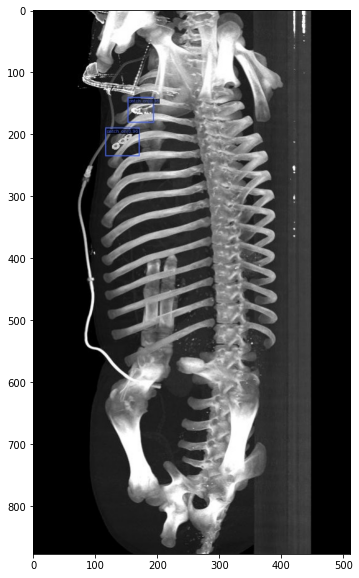

In [35]:
import skimage
import random
plt.figure(figsize=(15,10))
plt.imshow(skimage.io.imread(random.choice(list(local_output_data_dir.glob("*.jpg")))))

In [34]:
# %tensorboard --logdir /scratch/mjirik/job_12577867.meta-pbs.metacentrum.cz/data/processed/tutorial_exps

In [68]:


!cp  -r "$SCRATCHDIR"/data/processed/ /storage/plzen4-ntis/projects/korpusy_cv/pilsen_pigs_patches_processed/$(date +"%Y-%m-%d_%H%M")

In [46]:
!ls "$SCRATCHDIR"/data/processed/*

/scratch/mjirik/job_12614076.meta-pbs.metacentrum.cz/data/processed/demo_output.jpg
/scratch/mjirik/job_12614076.meta-pbs.metacentrum.cz/data/processed/pred_00001.jpg
/scratch/mjirik/job_12614076.meta-pbs.metacentrum.cz/data/processed/pred_00002.jpg
/scratch/mjirik/job_12614076.meta-pbs.metacentrum.cz/data/processed/pred_00003.jpg
/scratch/mjirik/job_12614076.meta-pbs.metacentrum.cz/data/processed/pred_00004.jpg
/scratch/mjirik/job_12614076.meta-pbs.metacentrum.cz/data/processed/pred_00005.jpg
/scratch/mjirik/job_12614076.meta-pbs.metacentrum.cz/data/processed/pred_00006.jpg
/scratch/mjirik/job_12614076.meta-pbs.metacentrum.cz/data/processed/pred_00007.jpg
/scratch/mjirik/job_12614076.meta-pbs.metacentrum.cz/data/processed/pred_00008.jpg
/scratch/mjirik/job_12614076.meta-pbs.metacentrum.cz/data/processed/pred_00009.jpg
/scratch/mjirik/job_12614076.meta-pbs.metacentrum.cz/data/processed/pred_00010.jpg
/scratch/mjirik/job_12614076.meta-pbs.metacentrum.cz/data/processed/pred_00011.jpg
/sc